# Passing Networks
Visualization and calculation the centralized nature of a game for teams involved.  Normally this is evaluated for one of the teams in a given game.  This helps to show the average shape of the team throughout the game.  Normally stopped at the first substution.

## Imports
This version will deviate from the Soccermatics approach due to the mplsoccer library throwing an error when making a call to Statsbomb.  Instead, the statsbomb data will be called directly for the dataframe from the statsbomb library.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch, Sbopen, VerticalPitch
from statsbombpy import sb

## Opening and creating the dataset
Using the sb parser in place of SBopen in mplsoccer the event data is pulled out. Calling on the event level data and inputting the id of the game as a parameter loads the game data. The event data is stored in a dataframe df. From this dataframe, the next step will be to filter for passes not including throw ins are left in the frame.

In [2]:
# get event data
df = sb.events(match_id=69301)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3291 entries, 0 to 3290
Data columns (total 90 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   bad_behaviour_card              1 non-null      object 
 1   ball_receipt_outcome            142 non-null    object 
 2   ball_recovery_recovery_failure  10 non-null     object 
 3   block_deflection                2 non-null      object 
 4   block_save_block                1 non-null      object 
 5   carry_end_location              765 non-null    object 
 6   clearance_aerial_won            12 non-null     object 
 7   clearance_body_part             57 non-null     object 
 8   clearance_head                  37 non-null     object 
 9   clearance_left_foot             4 non-null      object 
 10  clearance_other                 1 non-null      object 
 11  clearance_right_foot            15 non-null     object 
 12  counterpress                    88

In [4]:
df.query('type=="Pass"').loc[:,lambda df: df.columns.str.startswith('pass')].iloc[0]

pass_aerial_won                      NaN
pass_angle                      0.442374
pass_assisted_shot_id                NaN
pass_body_part                Right Foot
pass_cross                           NaN
pass_cut_back                        NaN
pass_deflected                       NaN
pass_end_location           [61.9, 40.9]
pass_goal_assist                     NaN
pass_height                  Ground Pass
pass_inswinging                      NaN
pass_length                      2.10238
pass_no_touch                        NaN
pass_outcome                         NaN
pass_recipient           Francesca Kirby
pass_shot_assist                     NaN
pass_straight                        NaN
pass_switch                          NaN
pass_technique                       NaN
pass_through_ball                    NaN
pass_type                       Kick Off
Name: 6, dtype: object

## Preparing the data
For passing networks only use accurate/successful passes made by a team until the first substitution. This is the most basic use case, and there are several possible variations using passing networks. They require information about pass start and end location as well as player who made and received the pass. To make the vizualisation clearer annotate the players using their surname. 

In [5]:
# find index of first sub for England
subs = df.loc[df["type"] == "Substitution"].loc[df["team"] == "England Women's"]['substitution_replacement'].to_list()
sub = df.loc[df["type"] == "Substitution"].loc[df["team"] == "England Women's"].iloc[0]["index"]
sub

1764

In [6]:
#make df with successfull passes by England until the first substitution

passnet = (df
 .query('type=="Pass" and team.str.startswith("Eng") and pass_outcome.isnull() and pass_type != "Throw-in"')
#  .loc[lambda df: df.index<sub]
 .query('~player.isin(@subs) and ~pass_recipient.isin(@subs)')
 .assign(x = lambda df: df.location.apply(pd.Series)[0],
         y = lambda df: df.location.apply(pd.Series)[1],
         xf = lambda df: df.pass_end_location.apply(pd.Series)[0],
         yf = lambda df: df.pass_end_location.apply(pd.Series)[1])
 .loc[:,['x', 'y', 'xf', 'yf', 'player', 'pass_recipient']]
 .assign(player_name = lambda df: df.player.str.split().str[1],
         pass_recipient_name = lambda df: df.pass_recipient.str.split().str[1])
 .drop(['player', 'pass_recipient'], axis=1)
)

In [7]:
passnet.head(2)

,x,y,xf,yf,player_name,pass_recipient_name
6,60.0,40.0,61.9,40.9,White,Kirby
7,82.6,37.6,78.4,58.5,Kirby,Bronze


In [8]:
subs

['Jodie Taylor', 'Karen Julia Carney', 'Rachel Daly']

In [9]:
passnet.player_name.unique()

array(['White', 'Kirby', 'Bronze', 'Parris', 'Moore', 'Mead', 'Greenwood',
       'Mitchell', 'McManus', 'Scott', 'Houghton'], dtype=object)

## Calculating vertices size and location
Using an empty dataframe, the vertices size and location will be calculated and stored for the passing network. Calculate the average location of passes made, average location of pass receptions, and the number of passes made for each player. This data will be leveraged to create the scatter plot for the network.  The marker size will be be proportional to number of passes completed.

--- 
Two solutions shown.  The first to based directly on Soccermatics, while the second is based a variant trying to use chaining options and vectorized operations as much as possible.

In [10]:
## soccermatics based solution
scatter_df = pd.DataFrame()
for i, name in enumerate(passnet["player_name"].unique()):
    passx = passnet.loc[passnet["player_name"] == name]["x"].to_numpy()
    recx = passnet.loc[passnet["pass_recipient_name"] == name]["xf"].to_numpy()
    passy = passnet.loc[passnet["player_name"] == name]["y"].to_numpy()
    recy = passnet.loc[passnet["pass_recipient_name"] == name]["yf"].to_numpy()
    scatter_df.at[i, "player_name"] = name
    #make sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
    #calculate number of passes
    scatter_df.at[i, "no"] = passnet.loc[passnet["player_name"] == name].count().iloc[0]

#adjust the size of a circle so that the player who made more passes
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

In [11]:
scatter_df.head(2)

,player_name,x,y,no,marker_size
0,White,80.414286,31.422857,17.0,447.368421
1,Kirby,61.851304,36.697391,54.0,1421.052632


In [12]:
scatter2_df = (pd.concat([(passnet
            .groupby('player_name')
            .agg({'x':'mean','y':'mean','player_name':'count'})),
           (passnet
            .groupby('pass_recipient_name')
            .agg({'xf':'mean','yf':'mean'}))],axis=1)
 .assign(x_fin = lambda df: (df.x+df.xf)/2,
         y_fin = lambda df: (df.y+df.yf)/2,
         passes_made = lambda df: df.player_name,
         marker_size = lambda df: df.player_name/df.player_name.max()*1500)
 .drop(['x','y','player_name','xf','yf'], axis=1)
 .reset_index()
 .rename(columns={'index':'player_name'})
)
scatter2_df.head(2)

,player_name,x_fin,y_fin,passes_made,marker_size
0,Bronze,53.579787,68.171577,46,1210.526316
1,Greenwood,59.878916,12.778653,43,1131.578947


## Calculating edges width
To calculate edge width look at the number of passes between players, and group the dataframe of passes by the combination of passer and recipient.  Then count passes of the pair. 

As the last step set a threshold ignoring players that made fewer than 2 passes. Try different thresholds and investigate how the passing network changes with different values. It is recommended that this be turned depedning on the message behind the visualisation.

---
Again, two solutions shown.  The first is the bare soccermatics default approach, and the second is vectorized if possible using chaining.

In [13]:
#counting passes between players
passnet["pair_key"] = passnet.apply(lambda df: "_".join(sorted([df["player_name"], df["pass_recipient_name"]])), axis=1)
lines_df = passnet.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
#setting a treshold. You can try to investigate how it changes when you change it.
lines_df = lines_df[lines_df['pass_count']>2]

In [14]:
passnet.head(2)

,x,y,xf,yf,player_name,pass_recipient_name,pair_key
6,60.0,40.0,61.9,40.9,White,Kirby,Kirby_White
7,82.6,37.6,78.4,58.5,Kirby,Bronze,Bronze_Kirby


In [15]:
lines_df.head(2)

,pair_key,pass_count
1,Bronze_Houghton,18
2,Bronze_Kirby,16


In [16]:
lines2_df = (passnet
 .assign(pass_pair = lambda df: passnet.apply(lambda df: "_".join(sorted([df["player_name"], 
                                                               df["pass_recipient_name"]])), axis=1))
 .groupby(["pair_key"]).x.count()
 .reset_index()
 .rename({'x':'pass_count'}, axis='columns')
 .query('pass_count>2')
)

In [17]:
lines2_df.head(2)

,pair_key,pass_count
1,Bronze_Houghton,18
2,Bronze_Kirby,16


## Plotting vertices
First plot the vertices (player positions) using the scatter_df created previously. This is also where annotatation of the player’s surname is conducted.

In [18]:
subs

['Jodie Taylor', 'Karen Julia Carney', 'Rachel Daly']

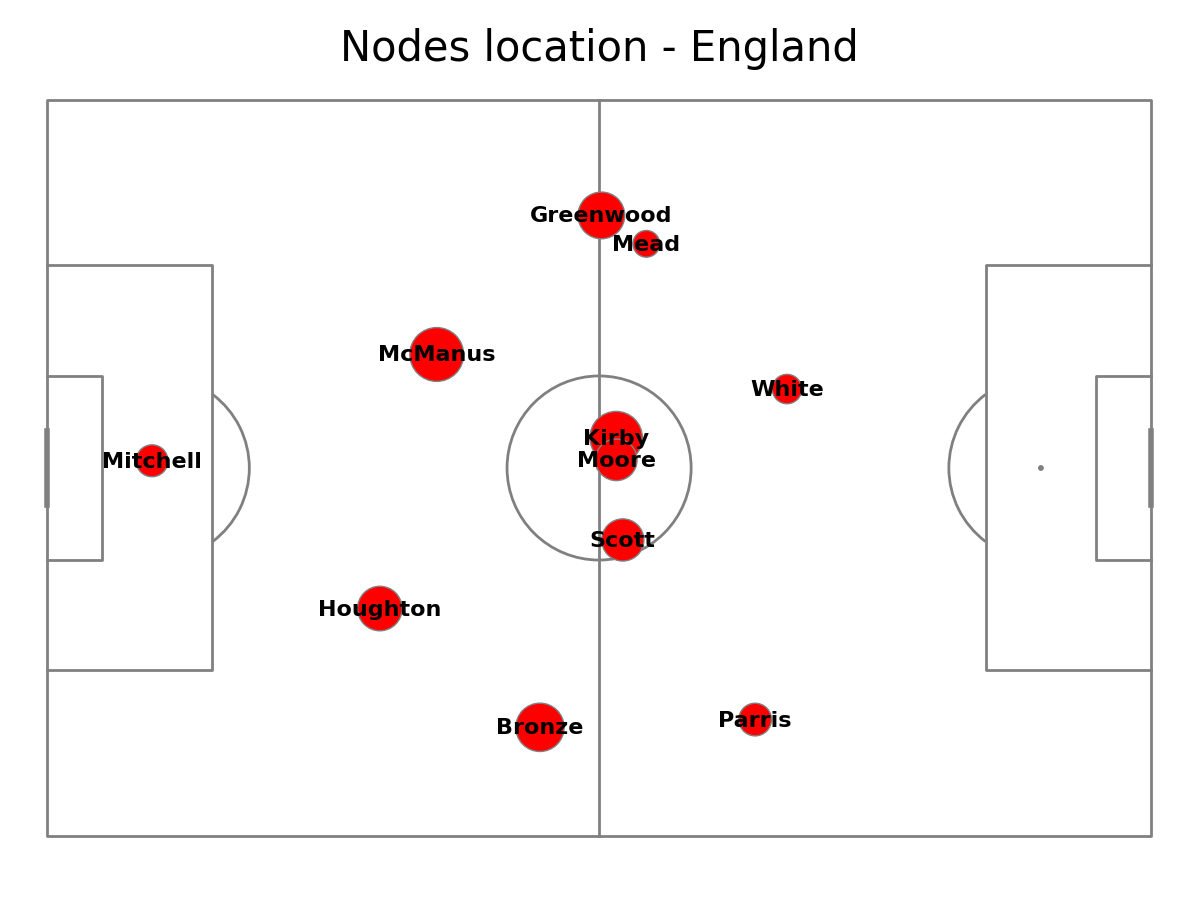

In [19]:
#Drawing pitch
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#Scatter the location on the pitch
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)
#annotating player name
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)

fig.suptitle("Nodes location - England", fontsize = 30)
plt.show()

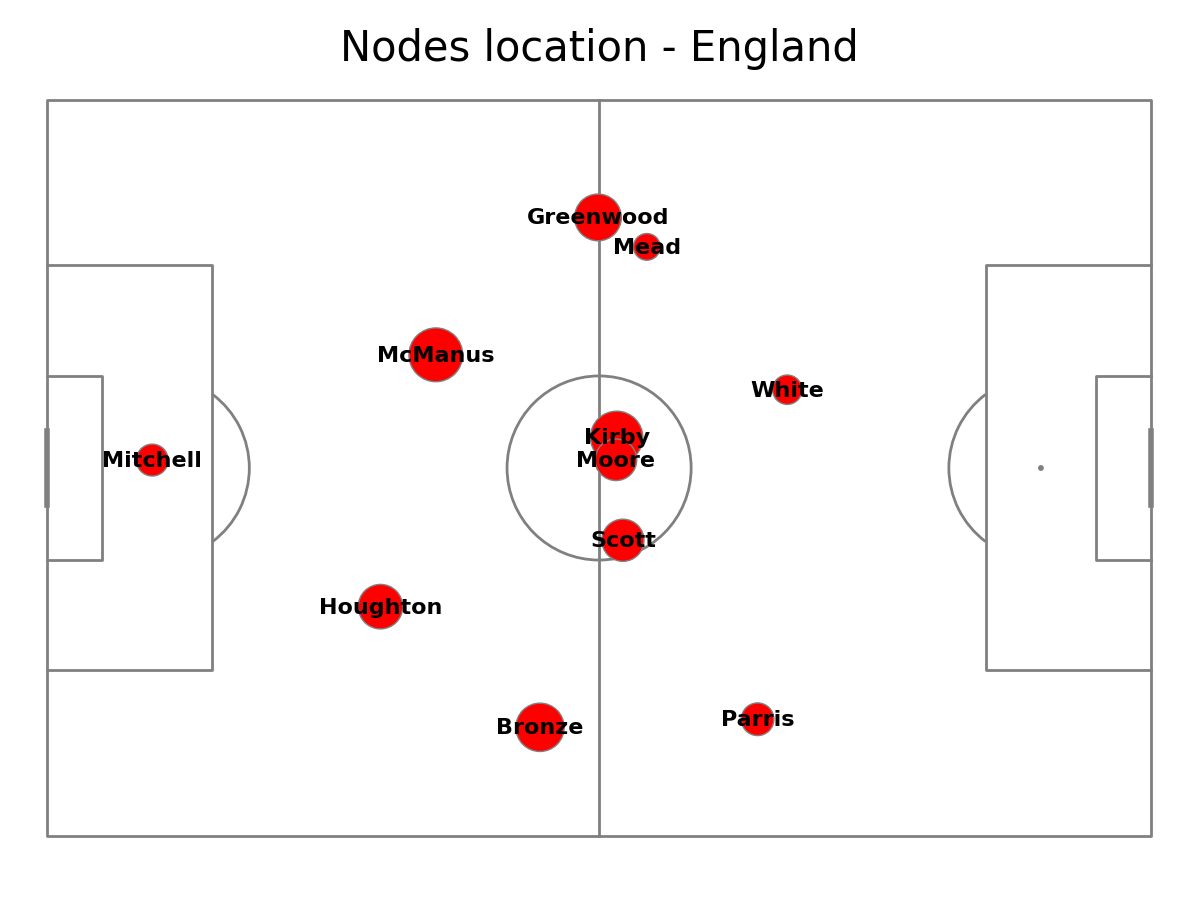

In [20]:
#Drawing pitch
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#Scatter the location on the pitch
pitch.scatter(scatter2_df.x_fin, scatter2_df.y_fin, s=scatter2_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)
#annotating player name
for i, row in scatter2_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x_fin, row.y_fin), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)

fig.suptitle("Nodes location - England", fontsize = 30)
plt.show()

## Plotting edges
For each combination of players who made passes, make a query to scatter_df to get the start and end of the line. Then  adjust the line width so that the more passes between players, the wider the line. Plot these lines on the pitch. It is recommended that zorder of edges is lower than zorder of vertices. Add a title for clarity.

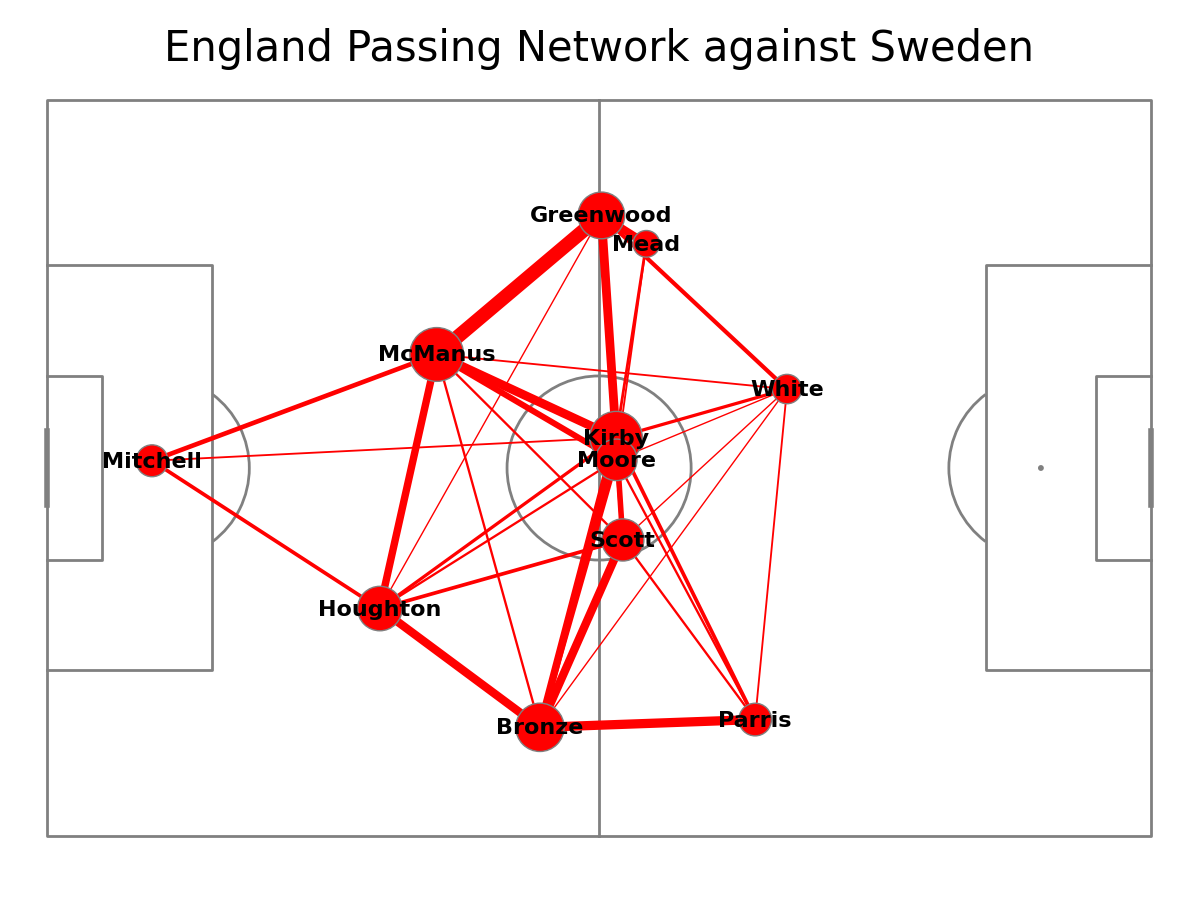

In [21]:
#plot once again pitch and vertices
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)

for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #take the average location of players to plot a line between them
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
        #adjust the line width so that the more passes, the wider the line
        line_width = (num_passes / lines_df['pass_count'].max() * 10)
        #plot lines on the pitch
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=1, lw=line_width, zorder=2, color="red", ax = ax["pitch"])

fig.suptitle("England Passing Network against Sweden", fontsize = 30)
plt.show()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

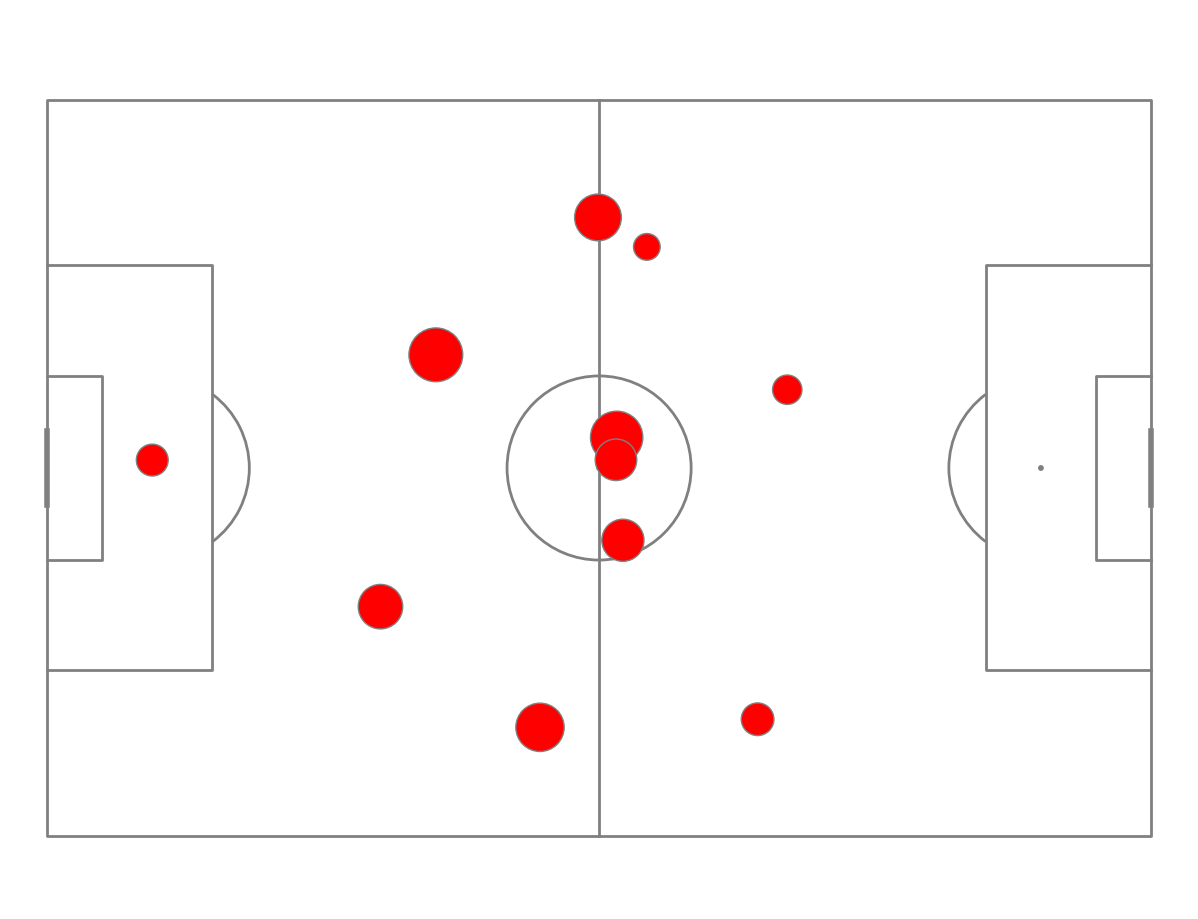

In [25]:
#plot once again pitch and vertices
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pitch.scatter(scatter2_df.x_fin, scatter2_df.y_fin, s=scatter2_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)
pitch.annotate(scatter2_df.player_name, xy=(scatter2_df.x_fin, scatter2_df.y_fin), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)

# for i, row in lines_df.iterrows():
#         player1 = row["pair_key"].split("_")[0]
#         player2 = row['pair_key'].split("_")[1]
#         #take the average location of players to plot a line between them
#         player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
#         player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
#         player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
#         player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
#         num_passes = row["pass_count"]
#         #adjust the line width so that the more passes, the wider the line
#         line_width = (num_passes / lines_df['pass_count'].max() * 10)
#         #plot lines on the pitch
#         pitch.lines(player1_x, player1_y, player2_x, player2_y,
#                         alpha=1, lw=line_width, zorder=2, color="red", ax = ax["pitch"])

fig.suptitle("England Passing Network against Sweden", fontsize = 30)
plt.show()